In [1]:
# %matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# %load common.py
import iris
import xarray
import os
from numcodecs import Blosc
import s3fs
import zarr
import intake
from datetime import datetime, timezone, timedelta
import cf_units
import json
import  dask_kubernetes
import distributed
import boto3
from iris.experimental.equalise_cubes import equalise_attributes
import pandas as pd
import sys
import numpy as np

sys.path.append(os.path.normpath(os.getcwd()))
from offsetmap import OffSetS3Map

sqs = boto3.client('sqs')

AWS_EARTH_TIME_FORMAT = '%Y-%m-%dT%H:%M:%SZ'
# SQS_QUEUE_URL = 'https://sqs.eu-west-2.amazonaws.com/536099501702/aws-earth-test'
SQS_QUEUE_URL = 'https://sqs.eu-west-2.amazonaws.com/536099501702/rolling_zarr_test_queue'

BUCKET = "metoffice-aws-earth-zarr"

def del_msg(msg):
    sqs.delete_message(
        QueueUrl=SQS_QUEUE_URL,
        ReceiptHandle=msg['receipt_handle']
    )
    
def get_messages(max_num=10):
    res = sqs.receive_message(QueueUrl=SQS_QUEUE_URL, MaxNumberOfMessages=max_num, VisibilityTimeout=60*10)
    messages  = []
    for message in res['Messages']:
        msg = json.loads(message['Body'])
        msg['receipt_handle'] = message['ReceiptHandle']
        messages.append(msg)
    return messages

def get_zar_path(meta):
    base = f"{BUCKET}/{meta['model']}-{meta['name']}"
    if meta.get('cell_methods', False):
        base += f"-{meta['cell_methods']}"
    if  meta.get('height', False) and (len(meta['height'].strip().split(' ')) > 1):
        base += '-at_heights'
    if meta.get('pressure', False) and (len(meta['pressure'].strip().split(' ')) > 1):
        base += '-at_pressures'
    return base + '.zarr'
    

def zarr_store(meta):
    return OffSetS3Map(root=get_zar_path(meta), temp_chunk_path=meta['name'], check=False)
    
def msg_to_path(msg):
    return f'/s3/{msg["bucket"]}/{msg["key"]}'

def reshape_to_dest_cube(cube):
    return iris.util.new_axis(iris.util.new_axis(cube, 'forecast_period'), 'forecast_reference_time')


def get_proto_zarr_array(meta):
    OffSetS3Map(root=get_zar_path(meta), temp_chunk_path=meta['name'], check=False)
    array_store = OffSetS3Map(root=get_zar_path(meta) +'/' + meta['name'], temp_chunk_path='', check=False)
    return zarr.open(array_store)

def meta_from_zarr_path(path):
    decompose = path
    decompose = decompose.rsplit('.',1)[0]
    meta = {}
    
    models = ['mo-atmospheric-global-prd', 'mo-atmospheric-mogreps-g-prd', 'mo-atmospheric-ukv-prd', 'mo-atmospheric-mogreps-uk-prd']
    for possiable_model in models:
        if path.startswith(possiable_model):
            model = possiable_model
        
    meta['model'] = model
    
    decompose = decompose.replace(model+'-', '')
    
    if path.find('-at_heights'):
        height = "0 1 2 3"
        meta['height'] = height
        decompose = decompose.replace('-at_heights', '')
        
    if path.find('-at_pressures') > 0:
        pressure = "1000 2000 3000" 
        meta['pressure'] = pressure
        decompose = decompose.replace('-at_pressures', '')
        
    meta['name'] = decompose 
    
    return meta

/opt/conda/lib/python3.6/site-packages/intake/source/discovery.py:39: UserWarning: Plugin name collision for "netcdf" from
    /opt/conda/lib/python3.6/site-packages/intake_iris/netcdf.py
and
    /opt/conda/lib/python3.6/site-packages/intake_xarray/netcdf.py
Keeping plugin from first location.
  % (plugin_name, orig_path, new_path))


In [3]:
# parameters
zarr_path = 'mo-atmospheric-mogreps-uk-prd-air_temperature-at_heights.zarr'

In [4]:
msg = meta_from_zarr_path(zarr_path)
store = zarr_store(msg)

In [5]:
%time
xds = xarray.open_zarr(store)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.77 µs


In [6]:
air_temperature= xds.air_temperature
cube = xds.air_temperature.to_iris()
cube

<iris 'Cube' of air_temperature / (K) (forecast_reference_time: 20; forecast_period: 55; realization: 12; height: 33; projection_y_coordinate: 970; projection_x_coordinate: 1042)>

CPU times: user 552 ms, sys: 204 ms, total: 756 ms
Wall time: 1.24 s


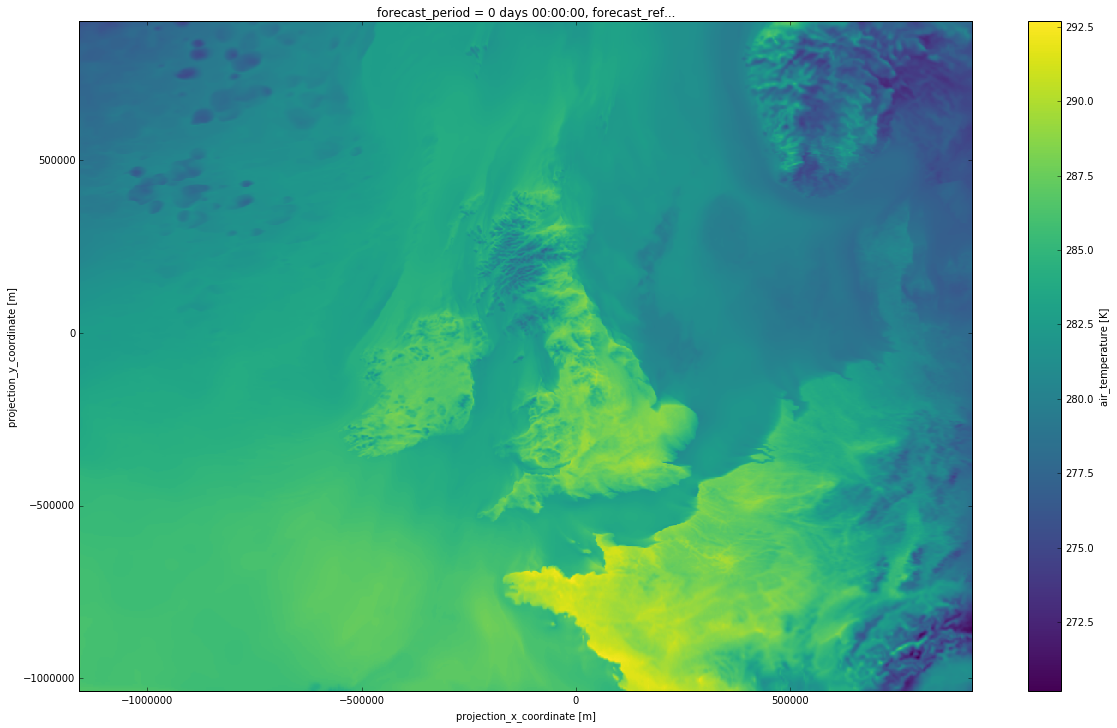

In [7]:
%%time
figsize(20, 12)
air_temperature[10,0,0,0].plot()

In [8]:
v_time = list(cube.coord('forecast_reference_time').cells())[-1].point
v_time_cubes = []
for i, f_ref in enumerate(cell.point for cell in cube.coord('forecast_reference_time').cells()):
    one_fcst_cube = cube[i] 
    diff = v_time - f_ref
    fcst_p_index = one_fcst_cube.coord('forecast_period').points.tolist().index(diff.seconds)
    v_time_cubes.append(one_fcst_cube[fcst_p_index])

In [9]:
truth_cube = v_time_cubes[-1] 

In [10]:
test_cube = iris.cube.CubeList(v_time_cubes).merge_cube()

In [15]:
a = test_cube.lazy_data()

In [18]:
list((len(o) for o in a.chunks))

[20, 4, 3, 1, 1]

In [19]:
20*4*3


240

In [12]:
true_data = da.stack([truth_cube.lazy_data() for i in range(test_cube.lazy_data().shape[0])])

NameError: name 'da' is not defined

In [ ]:
error = da.sqrt(da.square(true_data - test_cube.lazy_data()))
error

In [ ]:
error_cube = test_cube.copy(data=error)
error_cube.rename('error')
error_cube

In [ ]:
tot_error = error_cube.collapsed(['projection_y_coordinate', 'projection_x_coordinate','realization','height'], iris.analysis.SUM)
tot_error

In [42]:
tot_error

Error (K),forecast_reference_time
Shape,20
Dimension coordinates,
forecast_reference_time,x
Auxiliary coordinates,
forecast_period,x
Scalar coordinates,
height,"3002.5 m, bound=(5.0, 6000.0) m"
projection_x_coordinate,"-117000.0 m, bound=(-1158000.0, 924000.0) m"
projection_y_coordinate,"-67000.0 m, bound=(-1036000.0, 902000.0) m"
realization,"5, bound=(0, 11)"


In [44]:
import distributed
from dask_kubernetes import KubeCluster
cluster = KubeCluster()
cluster.adapt(minimum=1, maximum=200)
client = distributed.Client(cluster)
cluster

In [47]:
import matplotlib.pyplot as plt

import iris
import iris.plot as iplt

In [51]:
tot_error.data[0:1]

KilledWorker: ('zarr-31a6cb2c224d9c8e189e695aaf8b7193', 'tcp://100.96.45.54:45305')

In [48]:
iplt.plot(tot_error)
plt.show()

KilledWorker: ('zarr-31a6cb2c224d9c8e189e695aaf8b7193', 'tcp://100.96.45.54:45305')

KilledWorker: ('zarr-31a6cb2c224d9c8e189e695aaf8b7193', 'tcp://100.96.45.54:45305')

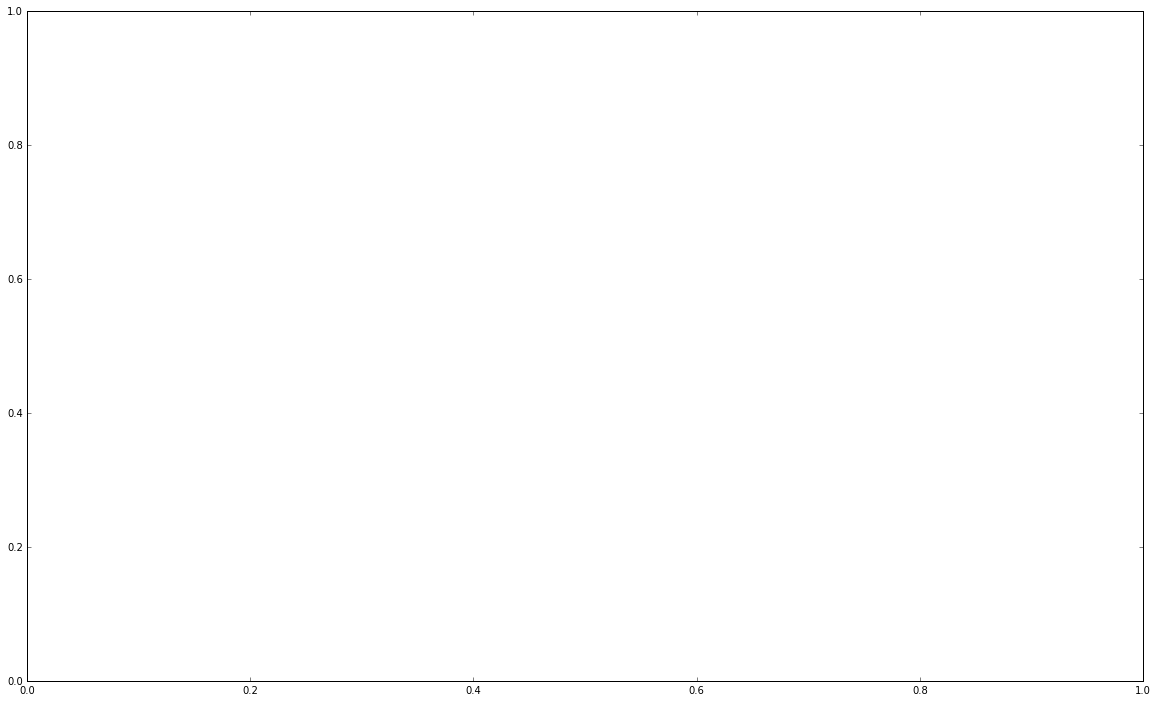

In [46]:
xarray.DataArray.from_iris(tot_error).plot()